<a href="https://colab.research.google.com/github/svngoku/NASA-Harvest-Field-Boundary-Detection-Challenge/blob/main/nasa_rwanda_field_boundary_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install radiant_mlhub patchify scipy keras rasterio SimpleITK

In [55]:
!cd datasets

In [58]:
!cd datasets & unzip Archive.zip

unzip:  cannot find or open Archive.zip, Archive.zip.zip or Archive.zip.ZIP.


In [59]:
import shutil

In [152]:
import pickle
import getpass
import pprint
import os
from PIL import Image
from patchify import patchify, unpatchify
from pathlib import Path
from typing import List, Optional, Tuple
from random import *
import SimpleITK as sitk

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
import rasterio as rio

In [9]:
from radiant_mlhub import Dataset

In [10]:
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

In [61]:
# shutil.unpack_archive("/content/datasets/Archive.zip", "/content/datasets/")

In [11]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [88]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']
img_batch_size = 256
img_heigth = 256
img_width = 256
img_channels = 4
num_channels = 24
input_shape = (
    256,
    256,
    num_channels
)
batch_size = 4

In [13]:
os.environ['MLHUB_API_KEY'] = getpass.getpass(prompt="MLHub API Key: ")
nasa_rwanda_field_boundary_dataset = Dataset.fetch_by_id("nasa_rwanda_field_boundary_competition")

MLHub API Key: ··········


## Functions


In [63]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [15]:
# Functions for data augmentation from 
# https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

In [78]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3], [0,1,2,3] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [16]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [158]:
def show_image(
    field : np.ndarray, 
    mask : np.ndarray
): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

In [163]:
def get_timestamp(
    img_heigth,
    img_width,
    img_channels
):
  #Get all timestamps
  timestamps = next(os.walk(f"/content/datasets/augmented_data"))[1]
  #Get all augmented tile ids. can just use one timestamp
  augmented_files = next(os.walk(f"/content/datasets/augmented_data/{timestamps[0]}/fields"))[2]
  X = np.empty((len(augmented_files), img_heigth, img_width, img_channels * len(timestamps)), dtype=np.float32) #time-series image
  y = np.empty((len(augmented_files), img_heigth, img_width, 1), dtype=np.uint8) #mask for each scene
  i = 0
  for file in augmented_files:
      idx = 0
      augmented_id = file.split('.pkl')[0] #id without .pkl extension
      temporal_fields = []
      for timestamp in timestamps:
          with open(f"/content/datasets/augmented_data/{timestamp}/fields/{augmented_id}.pkl", 'rb') as field:
              field = pickle.load(field) 
          X[i][:,:,idx:idx+img_channels] = field
          idx += img_channels
      with open(f"/content/datasets/augmented_data/{timestamp}/masks/{augmented_id}.pkl", 'rb') as mask:
          mask = pickle.load(mask)
      y[i] = mask.reshape(img_heigth, img_width, 1)
      i+=1

  return X,y,augmented_files

In [142]:
def apply_transformation_get_timestamp(
    train_tiles,
    train_source_items,
    train_label_items,
    dataset_id,
) -> None:
  for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"/content/datasets/augmented_data/{timestamp}"):
        os.makedirs(f"/content/datasets/augmented_data/{timestamp}")
    if not os.path.isdir(f"/content/datasets/augmented_data/{timestamp}/fields"):
        os.makedirs(f"/content/datasets/augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"/content/datasets/augmented_data/{timestamp}/masks"):
        os.makedirs(f"/content/datasets/augmented_data/{timestamp}/masks")
    #applying augmentation effects
    main(
        field=field,
        mask=mask,
        prefix=tile_id,
        write_folder=f"/content/datasets/augmented_data/{timestamp}"
    )

    get_timestamp(
        img_heigth,
        img_width,
        img_channels
    )

## Start coding

In [66]:
train_source_items = f"/content/datasets/{dataset_id}_source_train"
train_label_items = f"/content/datasets/{dataset_id}_labels_train"

In [21]:
# Download the source imagery if needed
# nasa_rwanda_field_boundary_dataset.download(output_dir="/content/datasets/",if_exists='overwrite')

  0%|          | 0/0.4 [00:00<?, ?M/s]

  0%|          | 0/112.5 [00:00<?, ?M/s]

  0%|          | 0/25.5 [00:00<?, ?M/s]

[PosixPath('/content/datasets/nasa_rwanda_field_boundary_competition_labels_train.tar.gz'),
 PosixPath('/content/datasets/nasa_rwanda_field_boundary_competition_source_train.tar.gz'),
 PosixPath('/content/datasets/nasa_rwanda_field_boundary_competition_source_test.tar.gz')]

In [24]:
nasa_rwanda_field_boundary_dataset_collection = nasa_rwanda_field_boundary_dataset.collections.source_imagery[0]

In [25]:
nasa_rwanda_field_boundary_dataset_collection.to_dict()

{'type': 'Collection',
 'id': 'nasa_rwanda_field_boundary_competition_source_train',
 'stac_version': '1.0.0',
 'description': 'nasa_rwanda_field_boundary_competition Train Source Imagery',
 'links': [{'rel': 'items',
   'href': 'https://api.radiant.earth/mlhub/v1/collections/nasa_rwanda_field_boundary_competition_source_train/items',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href': 'https://api.radiant.earth/mlhub/v1/',
   'type': 'application/json'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://api.radiant.earth/mlhub/v1/',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'Radiant MLHub API'},
  {'rel': 'self',
   'href': 'https://api.radiant.earth/mlhub/v1/collections/nasa_rwanda_field_boundary_competition_source_train',
   'type': 'application/json'}],
 'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json'],
 'assets': {},
 'sci:doi': '10.34911/rdnt.g580ww',
 'providers': [{'name': 'Radiant Earth Foundation',
  

In [67]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

In [71]:
tile = choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

06_2021_03


### Data Augmentation

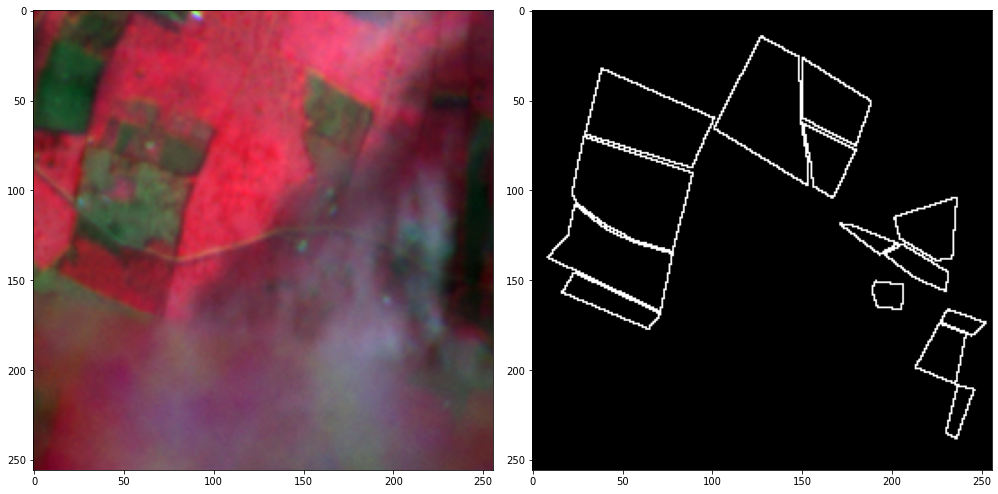

In [159]:
show_image(field, mask)

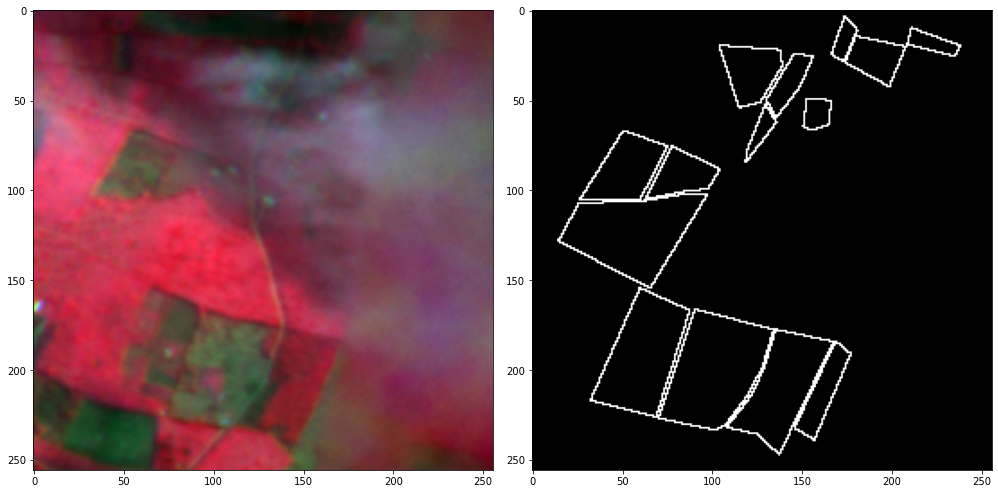

In [160]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

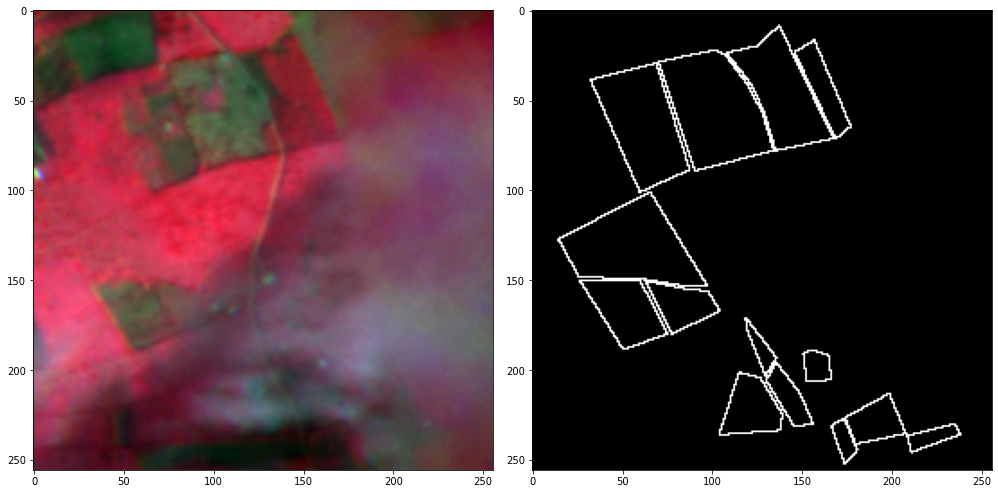

In [161]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

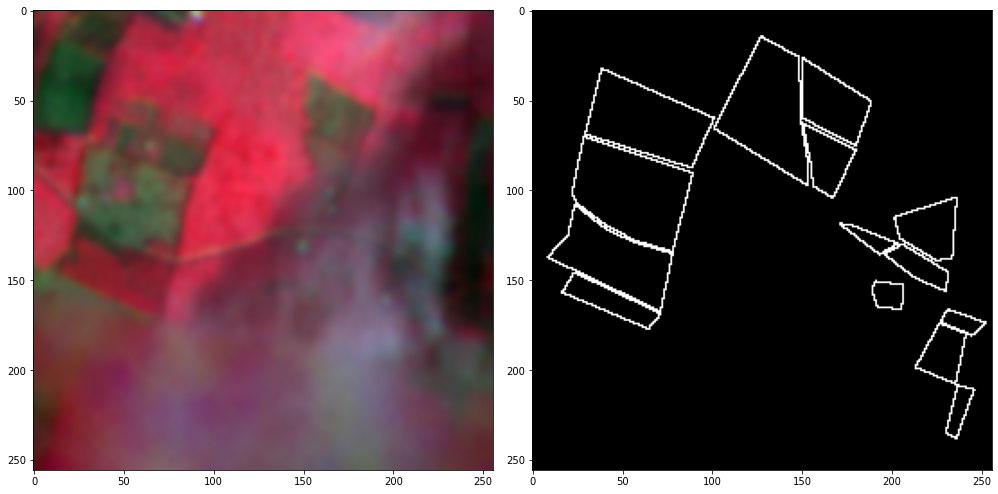

In [162]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

## Transformation

In [164]:
(X, y, augmented_files) = apply_transformation_get_timestamp(
    train_tiles,
    train_source_items,
    train_label_items,
    dataset_id,
)

TypeError: ignored

In [ ]:
randint(0, len(augmented_files)) #sanity check
random_image = randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:3], y[random_image])